### 📘 Model Training & Evaluation


<style>
.outer-div {
  text-align: left; /* Ensures content is left-justified */
  padding-left: 10px; /* Pads the content by 10px from the left */
  padding-bottom: 10px; /* Pads the content by 10px from the bottom */
}

.inner-div {
  width: 75%; /* Sets the width of the inner div to 75% of its parent */
  margin-left: 0; /* Ensures left justification if no other margin is applied */
  padding: 10px; /* Applies 10px padding on all sides */
  border-left: 1px solid #485c83; /* Left border: 1px solid with color #485c83 */
  color: #b8bbbf; /* Sets the font color */
  background-color: #303135; /* Sets the background color */
}
</style>
<div class="outer-div">
<div class="inner-div">
<b>Notebook Summary</b><br>
Goal: Train and evaluate baseline ML models<br>
Author: Dennis Fashimpaur<br>
Date: 2025-11-26<br>
Features: numeric-only, standardized<br>
Models: Logistic Regression, Random Forest<br>
Evaluation: Accuracy, Precision, Recall, F1, ROC-AUC
</div></div>

This notebook performs the following tasks:
* Loads unified dataset
* Drops duplicate `Amount` column
* Feature/label splitting
* Train/test split
* Standardization for Logistic Regression
* Trains Logistic Regression
* Trains Random Forest
* Evaluates models (precision, recall, F1, ROC-AUC)
* Displays Confusion matrices
* Compares models
* Plots ROC curves and Random Forest feature importance
* Saves trained models and results

### 🧭 Imports & Setup

In [1]:
import os

import joblib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, \
    roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from src.data_loader import load_csv

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 150)

### 📊 Load Unified Dataset

In [2]:
df = load_csv('../data/processed/unified_dataset.csv')
# Drop the redundant 'Amount' column per Option A
if 'Amount' in df.columns:
    df = df.drop(columns=['Amount'])
print("🗄️ Loaded unified dataset with shape:", df.shape)
df.head()

🗄️ Loaded unified dataset with shape: (289967, 42)


,V1,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V2,V20,V21,V22,V23,V24,V25,V26,V27,V28,V3,V4,V5,V6,V7,V8,V9,amount,cat_fuel,cat_grocery,cat_pharmacy,cat_restaurant,cat_tech,cat_travel,customer_id,day_of_week,hour_of_day,status,time_since_last,timestamp,label
0,0.913226,0.233487,0.681434,0.324081,-1.652084,0.974531,-1.019452,-0.425082,-0.174787,-0.318963,0.434814,-0.334869,-0.096506,0.118613,0.115522,-0.017332,0.076978,0.053263,1.104557,-0.322679,-0.205898,-1.131863,0.338485,-0.026602,-0.776100,0.374496,-0.209822,0.288196,0.0,0,0,0,0,0,0,217390.0,0,15,0,0.0,2023-01-02 15:07:52,0
1,-0.343731,-0.425360,0.102995,0.361722,0.346380,0.179415,1.105441,-0.365223,-0.103334,-0.915612,-0.690663,0.690284,-0.128852,-0.095639,-0.325158,0.014393,0.592538,-0.445124,-1.398906,0.018693,0.361152,1.226153,0.324928,0.103641,-0.335388,0.645968,-0.036795,-0.586683,0.0,0,0,0,0,0,0,41818.0,6,11,0,0.0,2023-01-01 11:20:41,0
2,0.575680,0.030164,1.473301,1.214818,0.488987,0.624722,0.314802,0.011253,-0.433739,-0.928824,0.178007,0.069638,0.022346,-0.396476,-1.323322,0.120628,-0.482128,0.433655,0.339656,-0.142786,0.006433,-0.087418,0.226253,0.156094,-0.181979,0.268919,-0.047594,-0.463394,0.0,0,0,0,0,0,0,14846.0,6,7,0,0.0,2023-01-01 07:15:25,0
3,0.946089,-0.186512,1.042947,0.335203,-1.089894,-0.665695,-1.027357,0.000233,0.952234,0.737060,-0.212151,0.129488,-0.161349,0.065360,0.166529,-0.079623,0.932803,0.760832,-1.134084,-0.055540,-0.065773,-1.568283,1.014384,0.661101,-0.490287,0.493573,-0.139013,-0.033381,0.0,0,0,0,0,0,0,249264.0,0,18,0,0.0,2023-01-02 18:52:03,0
4,-0.309597,0.707002,2.101898,0.319726,-0.773983,-0.426621,1.905974,-2.173136,1.056852,-1.217150,0.215612,0.127405,-0.116030,0.299150,2.216266,-0.301771,-1.608641,-1.746136,-0.166051,-1.086910,-1.644091,1.201845,0.860543,-0.113263,2.167935,0.894818,-0.106611,0.273161,0.0,0,0,0,0,0,0,69844.0,6,14,0,0.0,2023-01-01 14:53:27,0


### ䷖ Split Features & Labels
We keep only numeric features for modeling; the target column is `label` (1 = anomaly/fraud, 0 = normal).

In [3]:
X = df.drop(columns=['label'])
X = X.select_dtypes(include=['number'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (231973, 40)
Test shape: (57994, 40)


### 🔧 Standardize Features (for Logistic Regression)

Standardization rescales numeric features to have **mean 0 and standard deviation 1**.
- Helps Logistic Regression converge faster.
- Makes coefficient values more comparable across features.

In [4]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

### 💡 Evaluation Helper

In [5]:
def evaluate_model(y_test, y_pred, y_prob):
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob)
    }

### 📈 Logistic Regression — Overview & Train
Logistic Regression is a **supervised binary classification algorithm** that models the probability of the positive class (fraud/anomaly) using a logistic (sigmoid) function applied to a linear combination of features.

In [6]:
logreg = LogisticRegression(solver='lbfgs', max_iter=2000)
logreg.fit(X_train_scaled, y_train)
y_pred_lr = logreg.predict(X_test_scaled)
y_prob_lr = logreg.predict_proba(X_test_scaled)[:, 1]

### 📈 Logistic Regression — Evaluate

In [7]:
lr_metrics = evaluate_model(y_test, y_pred_lr, y_prob_lr)
pd.DataFrame([lr_metrics])

,accuracy,precision,recall,f1,roc_auc
0,0.99931,0.926471,0.642857,0.759036,0.991785


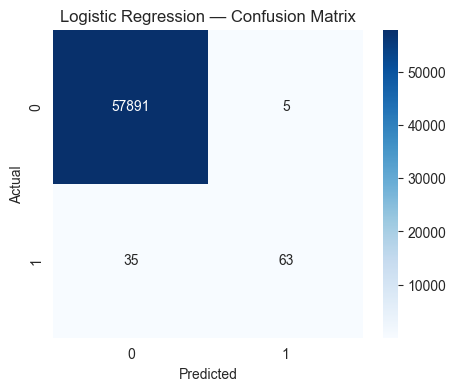

In [8]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression — Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 🌲 Random Forest — Overview & Train
Random Forest is an **ensemble of decision trees**:
- Each tree is trained on a random subset (bootstrap sample) of data.
- Splits consider a random subset of features.
- Final prediction is majority vote.
- Provides feature importance to understand which features contribute most.

In [9]:
rf = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

### 🌲 Random Forest — Evaluate

In [10]:
rf_metrics = evaluate_model(y_test, y_pred_rf, y_prob_rf)
pd.DataFrame([rf_metrics])

,accuracy,precision,recall,f1,roc_auc
0,0.999621,0.963415,0.806122,0.877778,0.990153


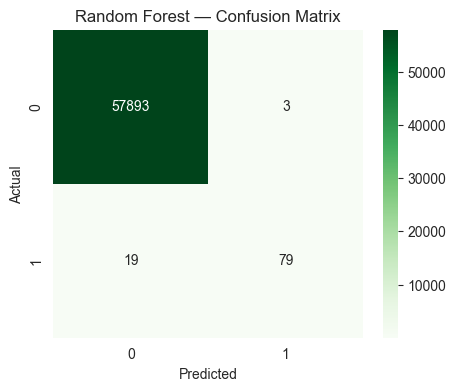

In [11]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title('Random Forest — Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 📊 ROC Curves — Model Comparison
ROC curve visualizes the trade-off between **True Positive Rate (Recall)** and **False Positive Rate** for different thresholds.
- Area Under Curve (AUC) shows discrimination ability: 1 = perfect, 0.5 = random.

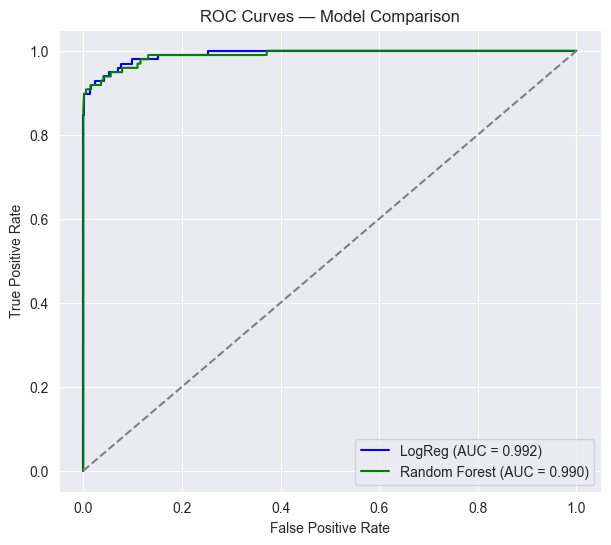

In [12]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(7, 6))
plt.plot(fpr_lr, tpr_lr, color='blue', label=f'LogReg (AUC = {roc_auc_lr:.3f})')
plt.plot(fpr_rf, tpr_rf, color='green', label=f'Random Forest (AUC = {roc_auc_rf:.3f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves — Model Comparison')
plt.legend()
plt.show()

### 🧩 Random Forest Feature Importance
Feature importance shows which features contribute most to the Random Forest's decisions.
- Higher importance = more influence on predictions.

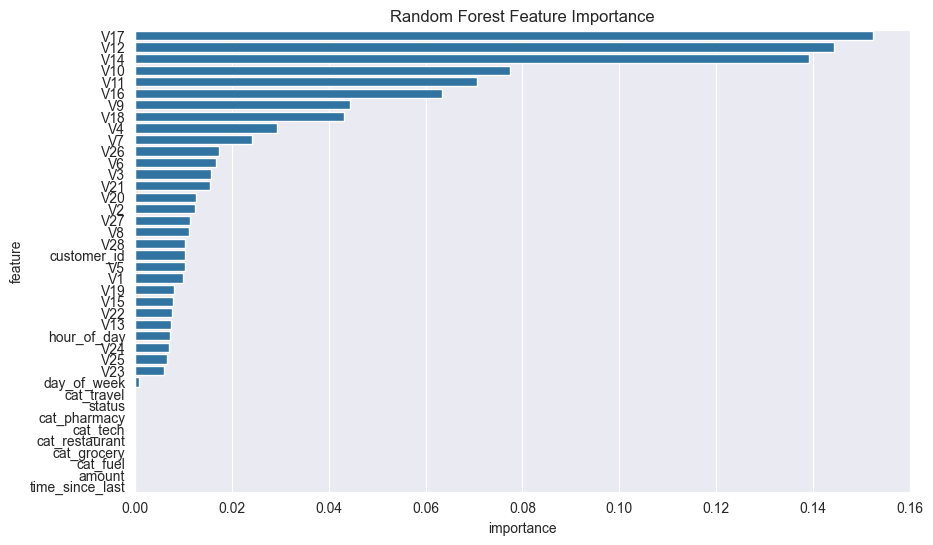

In [13]:
importances = rf.feature_importances_
feat_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances}).sort_values(by='importance',
                                                                                                       ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_importance_df)
plt.title('Random Forest Feature Importance')
plt.show()

### 🆚 Model Comparison

In [14]:
comparison = pd.DataFrame([
    {'model': 'Logistic Regression', **lr_metrics},
    {'model': 'Random Forest', **rf_metrics}
])
comparison

,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.999310,0.926471,0.642857,0.759036,0.991785
1,Random Forest,0.999621,0.963415,0.806122,0.877778,0.990153


### 💾 Save Models & Evaluation Results

In [15]:
os.makedirs('../data/models', exist_ok=True)
os.makedirs('../data/results', exist_ok=True)

# Save trained models
joblib.dump(logreg, '../models/logistic_regression.pkl')
joblib.dump(rf, '../models/random_forest.pkl')

# Save comparison results
comparison.to_csv('../data/results/model_results.csv', index=False)

print('💿 Saved models and results successfully.')

💿 Saved models and results successfully.
